In [23]:
%load_ext autoreload
%autoreload 2
import os
if os.path.basename(os.path.abspath(os.curdir)) == 'notebook':
    os.chdir('../.')

import sys
import torch
import os 
import sys
import pickle
from sketch_gnn.utils import flat_array
from sketch_gnn.dataloader.generate_dataModule import SketchGraphDataModule, generate_dataset
from sketch_gnn.models.gat import GaT
from sketch_gnn.models.predict import PredictSketch
from sketch_gnn.utils.to_dict import parse_config, yaml_to_dict
from sketch_gnn.utils.logger import logger

# SAVED_MODEL_PATH= 'Sandbox/gat_logs/version_15/checkpoints/gat-epoch=84-val_loss=0.00.ckpt'
# HPARAMS_PATH = 'Sandbox/gat_logs/version_15/hparams.yaml'

# SAVED_MODEL_PATH= 'Sandbox/gat_logs/version_30/checkpoints/gat-epoch=95-val_loss=0.00.ckpt'
# HPARAMS_PATH = 'Sandbox/gat_logs/version_30/hparams.yaml'

SAVED_MODEL_PATH= 'Sandbox/gat_logs/version_29/checkpoints/gat-epoch=95-val_loss=0.00.ckpt'
HPARAMS_PATH = 'Sandbox/gat_logs/version_29/hparams.yaml'

SEQUENCE_DATA= 'data/normalization_output_merged.npy'

# Load config
conf = parse_config('config/gat.yml')
d_train = conf.get('train')
d_val_data = conf.get('val_data')
d_train['batch_size'] = 1
d_val_data['prop_max_edges_given'] = 0.9
d_val_data['batch_size'] = 1
with open(conf.get('prep_parms_path'), 'rb') as f:
    d_prep = pickle.load(f)

d_model = yaml_to_dict(HPARAMS_PATH)
model = GaT(d_model, d_prep)

conf['edge_idx_map'] = d_prep.get('edge_idx_map')
conf['node_idx_map'] = d_prep.get('node_idx_map')

sketchPredictionmodel = PredictSketch.load_from_checkpoint(
    checkpoint_path=SAVED_MODEL_PATH,
    model= model,
    conf= None) # No need for training config
logger.info('-- Model initialization: end')

# Load dataloder 
graph_datamodule = SketchGraphDataModule(conf)
dataloader = graph_datamodule.val_dataloader()
batch_iterator = iter(dataloader)

# Load sequence dataset for visualization
sequence_data = flat_array.load_flat_array(SEQUENCE_DATA)

EDGE_IDX_MAP = d_prep.get('edge_idx_map')
NODE_IDX_MAP = d_prep.get('node_idx_map')

DEBUG:sketch_gnn.models.numerical_features.generator:{'POINT': {'status_construction': 2, 'x': 50, 'y': 50}, 'LINE': {'status_construction': 2}, 'CIRCLE': {'status_construction': 2, 'radius': 50}, 'ARC': {'status_construction': 2, 'radius': 50, 'angle_start': 50, 'angle_end': 50}}
INFO:sketch_gnn.utils.logger:-- Model initialization: end
INFO:sketch_gnn.dataloader.generate_dataModule:-- Load Validation Set


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from sklearn.metrics import precision_recall_curve
import numpy as np
import sklearn
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
%matplotlib inline
bs = 1
#https://stackoverflow.com/questions/49037902/how-to-interpolate-a-line-between-two-other-lines-in-python/49041142#49041142
def interp_curve(x,y, npoint=100):
    min_x, max_x = min(x), max(x)
    new_x = np.linspace(min_x, max_x, npoint)
    new_y = np.interp(new_x, x, y)
    return new_x, new_y

def mean_curve(xs,ys,npoint=100):
    assert len(xs) == len(ys)
    ncurves = len(xs)
    new_xs = np.zeros((ncurves,npoint))
    new_ys = np.zeros((ncurves,npoint))
    for i in range(ncurves):
        new_x, new_y = interp_curve(xs[i],ys[i],npoint)
        new_xs[i,:] = new_x
        new_ys[i,:] = new_y
    midx = [np.mean(new_xs[:,i],axis=0) for i in range(npoint)]
    midy = [np.mean(new_ys[:,i],axis=0) for i in range(npoint)]
    return midx, midy

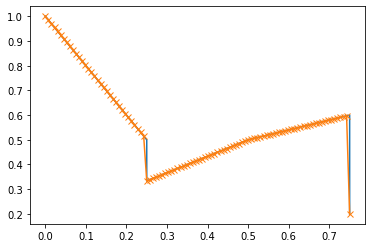

In [3]:
from sketch_gnn.inference.eval import EvalPrediction

# Interpolation

batch = next(batch_iterator)
output = model(batch)
pred = EvalPrediction(batch,output,EDGE_IDX_MAP,threshold=None)
pr, re, thresholds = precision_recall_curve(pred.true_label, pred.predicted_sigmoid)
# sort recall in ascending order, otherwise the np.interp won't work
inv_idx = list(range(len(pr)-1,0,-1))
re, pr = re[inv_idx], pr[inv_idx]
# [Optional] set pr(re=0) value to 1 (when threshold is too high and there is no detected positives, precision is undefined)
pr[re==0] = 1
interpx, interpy = interp_curve(re, pr,100)
plt.plot(re,pr)
plt.plot(interpx,interpy,marker='x')

In [4]:
# # [NOT USED] Add name of constraint into the binary sigmoid prediction to obtain a 2 head pr curve
# # Bug: Choosing the wrong type leads to a persistent false negative. 
# # This means that the recall cannot possibly be one and the curve stops before the (re=1,pr=0) point.

# def two_heads_target_sigmoid(pred):
#     n_label_1 = int(sum(pred.true_label))
#     type_is_ok = pred.predicted_type[:n_label_1] == pred.true_type[:n_label_1]
#     n_wrong_types = int(np.sum(~type_is_ok))
#     new_target = np.concatenate([pred.true_label, np.ones(n_wrong_types)]).astype(bool) # add a 1 for each constraint with a wrong type
#     new_target[:n_label_1] &= type_is_ok #if wrong type then set target to zero
#     new_sigmoid = np.concatenate([pred.predicted_sigmoid, np.zeros(n_wrong_types)]) # add a 0 for each constraint with a wrong type
#     return new_target, new_sigmoid

# # batch = next(batch_iterator)
# # output = model(batch)
# pred = EvalPrediction(batch,output,EDGE_IDX_MAP,threshold=None)
# new_target, new_sigmoid = two_heads_target_sigmoid(pred)
# pr, re, thresholds = precision_recall_curve(new_target,new_sigmoid)
# # sort recall in ascending order, otherwise the np.interp won't work
# inv_idx = list(range(len(pr)-1,0,-1))
# re, pr = re[inv_idx], pr[inv_idx]
# # [Optional] set pr(re=0) value to 1 (when threshold is too high and there is no detected positives, precision is undefined)
# pr[re==0] = 1
# interpx, interpy = interp_curve(re, pr,100)
# plt.plot(re,pr)
# plt.plot(interpx,interpy,marker='x')

In [24]:
# Inference loop
pr_b = []
re_b = []
l_true_type = []
l_predicted_type = []
l_true_label = []
l_predicted_sigmoid = []
dataloader = graph_datamodule.val_dataloader()
batch_iterator = iter(dataloader)
log = 0
for b in batch_iterator:
    log+=1
    if log%500==0:
        print(log)
        break
    output = model(b)
    
    # Binary head only
    pred = EvalPrediction(b,output,EDGE_IDX_MAP,threshold=None)
    pr, re, thresholds = precision_recall_curve(pred.true_label, pred.predicted_sigmoid)
    
    # # Two heads
    # # new_target, new_sigmoid = two_heads_target_sigmoid(pred)
    # # pr, re, thresholds = precision_recall_curve(new_target,new_sigmoid)
    
    inv_idx = list(range(len(pr)-1,0,-1))
    re, pr = re[inv_idx], pr[inv_idx]
    pr[re==0] = 1 # set pr(re=0) value to 1
    pr_b.append(pr)
    re_b.append(re)
    
    l_true_type.append(pred.true_type)
    l_predicted_type.append(pred.predicted_type)
    l_true_label.append(pred.true_label)
    l_predicted_sigmoid.append(pred.predicted_sigmoid)

INFO:sketch_gnn.dataloader.generate_dataModule:-- Load Validation Set


500


# Mean PR Curve

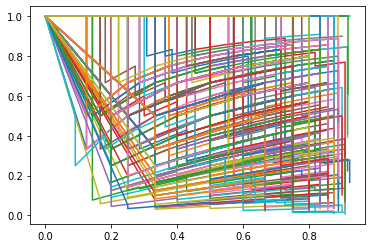

In [25]:
for pr,re in zip(pr_b, re_b):
    plt.plot(re,pr)

In [26]:
mean_re, mean_pr = mean_curve(re_b, pr_b)

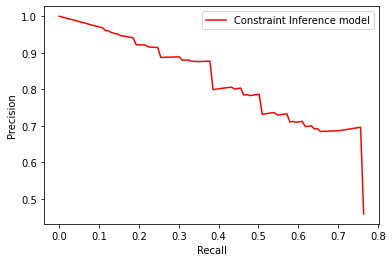

In [27]:
fig, ax = plt.subplots()
plt.plot(mean_re,mean_pr, color='red', label='Constraint Inference model')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# plt.savefig('pr_curve.png')

In [28]:
def make_list(t):
    l = []
    for i in t:
        l += list(i)
    return l
n_sktchs = 30
pr_l = make_list(pr_b[:n_sktchs])
re_l = make_list(re_b[:n_sktchs])

In [10]:
# xypr = np.vstack([re_l,pr_l])
# gkde_estimator = gaussian_kde(xypr)
# zpr = gkde_estimator(xypr)

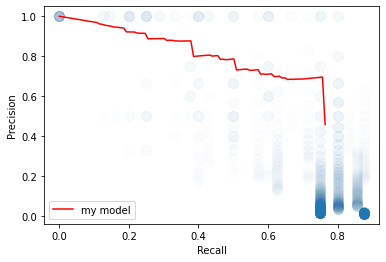

In [29]:
fig, ax = plt.subplots()
density2 = ax.scatter(re_l, pr_l, alpha=0.01, s=100)
# density2 = ax.scatter(re_l, pr_l,c=zpr, s=100)
# fig.colorbar(density2, label='Number of points per pixel')
plt.plot(mean_re,mean_pr, color='red', label='my model')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# Confusion matrix

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
l_true_type_cut = [true_type_[:len(predicted_type_)] for (true_type_, predicted_type_) in zip(l_true_type,l_predicted_type)] #remove given edges
true_type = np.concatenate(l_true_type_cut)
true_label = np.concatenate(l_true_label)
predicted_type = np.concatenate(l_predicted_type)
predicted_sigmoid = np.concatenate(l_predicted_sigmoid)
index_none = len(EDGE_IDX_MAP) - 1

## Classification Head confusion matrix

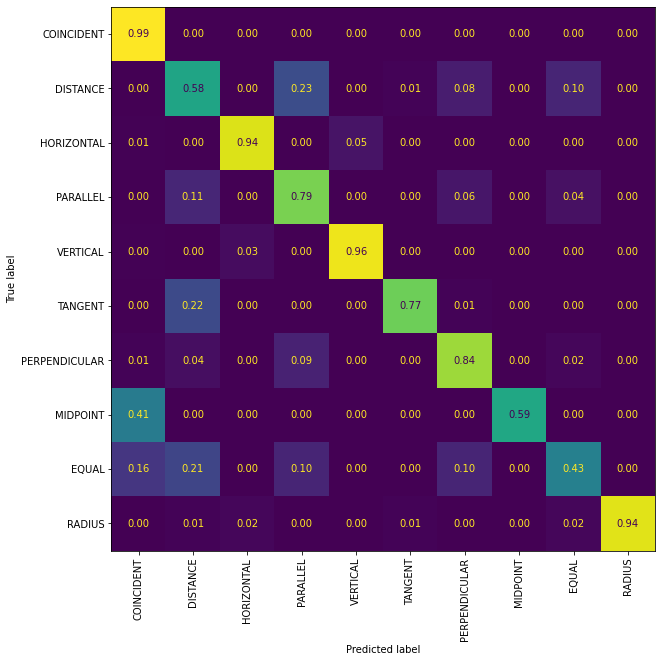

In [13]:
label_names = list(EDGE_IDX_MAP.keys())[:-1]
labels = list(np.arange(len(label_names)))
# Remove labels that are too rare
for name in ['HORIZONTAL_DISTANCE','VERTICAL_DISTANCE','ANGLE','LENGTH']:
    label_names.remove(name)
    labels.remove(EDGE_IDX_MAP[name])
# label_names = list(map(str.capitalize,label_names))
cm = confusion_matrix(true_type, predicted_type, labels=labels, normalize='true')
cm = cm.astype(float)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_names,
)
fig, ax = plt.subplots()
# fig.set_dpi()
fig.set_size_inches(10,10)
disp = disp.plot(ax=ax,xticks_rotation='vertical',include_values=True,values_format='.2f',colorbar=False)
# fig.savefig('confusion_head.png')

## 2 Heads Confusion Matrix

We add the information from the binary head into the class prediction by adding a 'None' class.

True negatives (i.e true:None/pred:None) are set to zero to avoid disrupting the color map

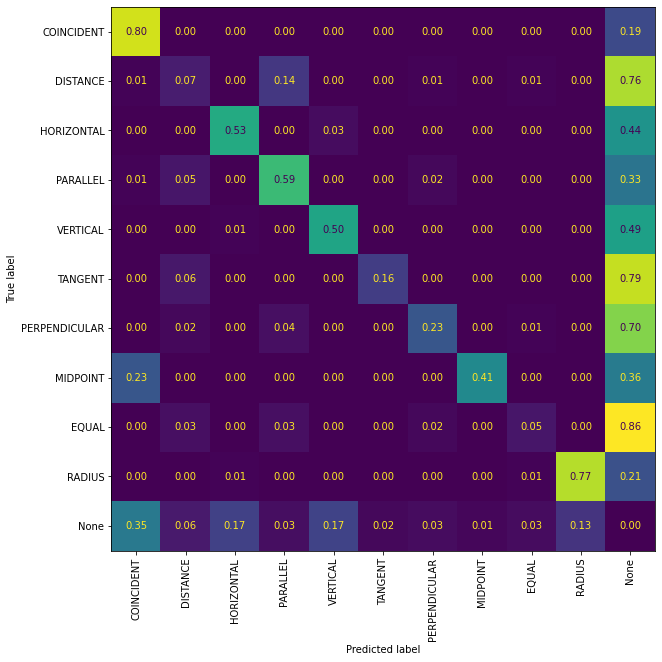

In [34]:
import copy
predicted_type_ = copy.deepcopy(predicted_type)
true_type_ = copy.deepcopy(true_type)
thr = 0.95
predicted_label = predicted_sigmoid > thr
predicted_type_[predicted_label==0] = index_none
true_type_[true_label==0] = index_none

label_names = list(EDGE_IDX_MAP.keys())[:-1] + ['None']
labels = list(np.arange(len(label_names)))
# Remove labels that are too rare
for name in ['HORIZONTAL_DISTANCE','VERTICAL_DISTANCE','ANGLE','LENGTH']:
    label_names.remove(name)
    labels.remove(EDGE_IDX_MAP[name])
# label_names = list(map(str.capitalize,label_names))
cm = confusion_matrix(true_type_, predicted_type_, labels=labels, normalize=None)
cm = cm.astype(float)
cm[-1,-1] = 0 # remove True Negatives (otherwise this would mess up the colors)
cm /= np.sum(cm,axis=1).reshape(-1,1)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_names,
)
fig, ax = plt.subplots()
# fig.set_dpi()
fig.set_size_inches(10,10)
disp = disp.plot(ax=ax,xticks_rotation='vertical',include_values=True,values_format='.2f',colorbar=False)
# fig.savefig('confusion.png')

In [35]:
report = sklearn.metrics.classification_report(true_type_,predicted_type_,labels=labels,target_names=label_names)
print(report)

               precision    recall  f1-score   support

   COINCIDENT       0.78      0.80      0.79      1335
     DISTANCE       0.09      0.07      0.08        99
   HORIZONTAL       0.51      0.53      0.52       271
     PARALLEL       0.59      0.59      0.59       114
     VERTICAL       0.43      0.50      0.46       225
      TANGENT       0.55      0.16      0.24       108
PERPENDICULAR       0.49      0.23      0.31       108
     MIDPOINT       0.53      0.41      0.46        39
        EQUAL       0.11      0.05      0.07        58
       RADIUS       0.44      0.75      0.55       110
         None       1.00      1.00      1.00    187524

    micro avg       0.99      0.99      0.99    189991
    macro avg       0.50      0.46      0.46    189991
 weighted avg       0.99      0.99      0.99    189991



## Statistics on couples of primitives

The figures represent the model's performance on every couple of primitives, e.g. POINT-POINT or POINT-LINE.

Some might be easier to infer (POINT-POINT coincident) and some may not exist (LINE-POINT Horizontal)

For easier representation, self loops (i.e A-A) are not differentiated from standard edges (i.e. A-B). This means that 'POINT-A POINT-A' edges will be grouped with 'POINT-A POINT-B' edges.
This is usually not a problem but it may lead to false interpretations.

INFO:sketch_gnn.dataloader.generate_dataModule:-- Load Validation Set


----------
Constraint = COINCIDENT
----------


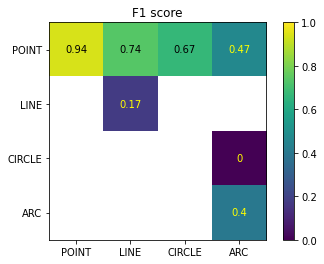

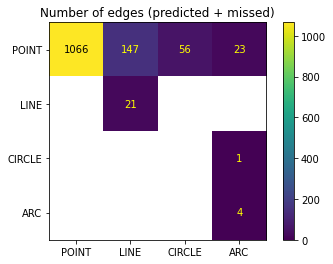

In [16]:
from collections import defaultdict, Counter
conf['train']['batch_size'] = 500
graph_datamodule = SketchGraphDataModule(conf)
dataloader = graph_datamodule.val_dataloader()
batch_iterator = iter(dataloader)
batch = next(batch_iterator)
output = model(batch)
pred = EvalPrediction(batch, output, EDGE_IDX_MAP, threshold=0.99)

# =============== Specify name of constraint here =================== #
# constraint_name = 'HORIZONTAL'
# constraint_name = 'EQUAL'
constraint_name = 'COINCIDENT'

d_name_set = defaultdict(list)
# REVERSE_NODE_IDX_MAP = ['POINT', 'LINE', 'CIRCLE', 'ARC', 'SN_pnt1', 'SN_pnt2', 'SN_center', 'void']
REVERSE_NODE_IDX_MAP = ['POINT', 'LINE', 'CIRCLE', 'ARC', 'POINT', 'POINT', 'POINT']
BASIC_PRIMITIVES = ['POINT', 'LINE', 'CIRCLE', 'ARC']

for idx in range(len(pred.predicted_sigmoid)):
    i0, i1 = pred.references[idx]
    edge_i0 = batch['x'][:,0][i0]
    edge_i1 = batch['x'][:,0][i1]
    key = frozenset([
        REVERSE_NODE_IDX_MAP[edge_i0],
        REVERSE_NODE_IDX_MAP[edge_i1],
        ])
    if isinstance(constraint_name,str) and constraint_name != pred.true_type_name[idx]:
        continue
    d_name_set[key].append(idx)

pre_matrix = np.zeros((4,4))*np.nan
rec_matrix = np.zeros((4,4))*np.nan
tot_matrix = np.zeros((4,4))*np.nan

for i, name in enumerate(BASIC_PRIMITIVES):
    for j, name2 in enumerate(BASIC_PRIMITIVES[i:]):
        query_name_set = frozenset([name,name2])
        l_idxes = d_name_set[query_name_set]
        categories = pred.edges_category[l_idxes]
        count = Counter(categories)
        tp = count['true_positives']
        fp = count['false_positives'] + count['false_positives_wrong_type']
        fn = count['false_negatives'] + count['false_positives_wrong_type'] + count['false_negatives_wrong_type']
        total = len(l_idxes) - count['true_negatives']
        pre = 0. if not tp else tp / (tp + fp)
        rec = 0. if not tp else tp / (tp + fn)
        if total == 0:
            continue
        # print(f'{name:6}- {name2:6} precision: {pre:5.2}, recall {rec:5.2}, total {total}')
        pre_matrix[i,i+j] = pre
        rec_matrix[i,i+j] = rec
        tot_matrix[i,i+j] = total



def plot_matrix(matrix, vmin = None, vmax = None):
    fig, ax = plt.subplots()
    if vmin is None:
        vmin = np.min(matrix[~np.isnan(matrix)])
    if vmax is None:
        vmax = np.max(matrix[~np.isnan(matrix)])
    plt.imshow(matrix, vmin=vmin, vmax=vmax)
    ax.set_xticks(np.arange(4))
    ax.set_yticks(np.arange(4))
    ax.set_xticklabels(BASIC_PRIMITIVES)
    ax.set_yticklabels(BASIC_PRIMITIVES)
    for (j,i),label in np.ndenumerate(matrix):
        if np.isnan(label):
            continue
        else:
            rounded = round(label,2)
            if rounded%1 == 0:
                rounded = int(rounded) 
            color = 'black' if rounded > (vmax-vmin)/2 else 'yellow'
        ax.text(i,j,rounded,ha='center',va='center', color=color)
    return fig, ax

print("-"*10)
print(f"Constraint = {constraint_name}")
print("-"*10)

f1_matrix = 2*pre_matrix*rec_matrix/(pre_matrix + rec_matrix + 1e-5)
plot_matrix(f1_matrix, vmin = 0, vmax = 1)
plt.colorbar()
plt.title('F1 score')

plot_matrix(tot_matrix, vmin = 0)
plt.colorbar()
_ = plt.title('Number of edges (predicted + missed)')